Power in the source plane:   Pin  =    1.8454 mW
Power in the field plane:   Pout  =    1.8453 mW


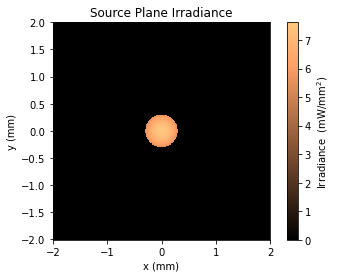

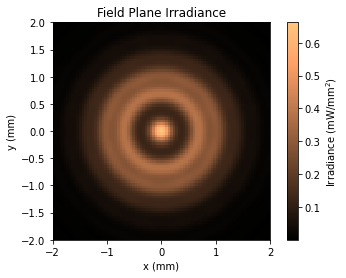

In [2]:
# Code Written By Dr. Andri Gretersson
# Adpated by Benjamin Hogan

# ------------------------------------------------------------------------------
# FOURIER OPTICS DEMONSTRATION
# Language: Python 3
# ------------------------------------------------------------------------------ 
# Calculates the optical intensity on a screen due to aperture diffraction. 
# The complex scalar field u(x,y) in the  source plane is a concave sperical 
# phasefront (ROC=0.5 m) passing through a circular aperture. The resulting 
# complex scalar field amplitude u'(x',y') in the "field plane" is calculated 
# via Fourier transform.
# ------------------------------------------------------------------------------

import numpy as np
import numpy.matlib as npm
import matplotlib.pyplot as plt

# --------------------
# Physical Parameters
# --------------------
c = 3e8                                             # speed of light in m/s
epsilon0 = 8.854e-12                                # vacuum permittivity in F/m
lam = 633e-9                                        # optical wavelength in m

# -------------
# Source plane
# -------------
xmax=0.002                                          # Src plane area: 4*xmax*ymax m^2
ymax=xmax                                          
Nx = int(2**np.ceil(np.log2(np.abs(512))))          # number of pixels in source plane grid is Nx*Ny
Ny = int(2**np.ceil(np.log2(np.abs(512))))          # (2**... etc gives next power of two for speed)
dxp = 2*xmax/(Nx-1);  dyp=2*ymax/(Ny-1)             # interpixel dist. in the src plane (m)
xp  = npm.repmat( ((np.arange(0,Nx))-np.floor(Nx/2)) *dxp, Ny,1) # x' values at which to calc. source field
yp  = np.transpose(npm.repmat( ((np.arange(0,Ny))-np.floor(Ny/2)) *dyp, Nx,1));  # and y' values

# -----------------------
# ABCD Matrix Components
# -----------------------
# Optical system consists of [ FREE SPACE : LENS : FREE SPACE ].  
L1 = 0.035 ;#0.1e-3;                                # aperture-lens dist. in m
L2 = 0.12;                                          # lens-screen dist. in m
f  = -0.03;                                         # f=Inf corresponds to no lens 
M = np.array([[1,L2],[0,1]]) \
    @ np.array([[1,0],[-1/f,1]]) \
    @ np.array([[1,L1],[0,1]])                      # ABCD matrix of the system
AA = M[0,0]; BB = M[0,1]; CC = M[1,0]; DD = M[1,1]; # The components A, B, C, D

# ---------
# Aperture
# ---------
# Field amplitude is non-zero at these values of x, y (i.e. where it passes 
# through the aperture). The apertures are defined as logical matrixes that 
# are used to index the source field distribution, i.e. Usource(~aperture)=0;
# UIsource(aperture)= <something nonzero>.

#a = 50*1e-6;                                        # circular obstrution diam. (m)
#b = 600e-6;                                         # off-center scale factor
#aperture = (xp+0.75*b)**2+(yp-0.35*b)**2 > (a/2)**2 # circular obstruction logical mask

a = 3*1e-6;                                      # triangle side length (m)
#aperture = np.logical_and.reduce([(yp<np.sqrt(3)*xp+a/2/np.sqrt(3)), \
#            (yp<-np.sqrt(3)*xp+a/2/np.sqrt(3)), \
#            (yp>-a/2/np.sqrt(3))])                  # equil. triangular aperture
x0, y0 = 0, 0  # center of the circle
r = 300e-6  # radius of the circle
aperture = np.logical_and.reduce([(xp - x0)**2 + (yp - y0)**2 <= r**2])
#a = 300e-6                                          # triangle side length (m)
#b = 600e-6                                          # off-center scale factor
#aperture = np.logical_not(np.logical_and.reduce(\
#           [((yp-0.35*b)<np.sqrt(3)*(xp+0.75*b)+a/2/np.sqrt(3)), \
#           ((yp-0.35*b)<-np.sqrt(3)*(xp+0.75*b)+a/2/np.sqrt(3)), \
#           ((yp-0.35*b)>-a/2/np.sqrt(3))]))         # equil. triangular aperture        # equil. triangular obstruction

# -------------
# Source Field 
# -------------
# Here, the incident field is assumed to be a Gaussian beam of width "w" 
# and radius of curvature "roc". The beam is clipped by the apeture.
roc = 0.5;                                          # R.O.C. of phasefront at src plane (m)
w  = 750e-6;                                        # beam width of incident beam (m) 
I0 = 7617.5;                                          # max src plane intensity (W/m^2)
E0 = np.sqrt(2*I0/c/epsilon0);                      # m ax field ampl. in src plane (N/C)
k = 2*np.pi/lam;                                    # wave number
r = np.sqrt(xp**2+yp**2);                           # src plane coordss dist from center
usource = E0*np.exp(-r**2/w**2)*np.exp(1j*k*r**2/2/roc); # field ampl. in src plane
usource[np.logical_not(aperture)]=0;                # field is zero except in the aperture
Isource = epsilon0*c/2*np.abs(usource)**2;          # Intensity in the source plane (W/m^2)

# ========================================================================================
# |+|+|+|+|  THE COMPUTATION OCCURS BETWEEN THIS LINE AND THE ONE LIKE IT BELOW  |+|+|+|+|
# ========================================================================================

# h, below is a scale factor to change from the physical units (meters) to new units in
# which all physical lengths are scaled by h=sqrt(B*lam). In the new units, the Fresnel
# integral becomes a standard Fourier transform multiplied by a phase factor. We now scale
# all physical lengths to the new units before performing the fourier tranform. Due to the 
# limitations placed on variable names, x' in the text is the variable f here, y' is g, 
# X' is F, and Y' is G.

h = np.sqrt(BB*lam);                                # scaling factor
dXp = dxp/h; dYp = dyp/h;                           # src interpixel dist in the new units
Xp = xp/h;                                          # src plane x-coords scaled to new units
Yp = yp/h;                                          # src plane y-coords scaled to new units

dX = 1/dXp/Nx;  dY = 1/dYp/Ny;                      # corresponding spatial sampling interval 
                                                    # in field plane after 2 dim. FFT (fft2).
X=npm.repmat((np.arange(0,Nx)-np.floor(Nx/2))  *dX,Ny,1); # Field plane, x-domain (in scaled length)
Y=np.transpose(npm.repmat((np.arange(0,Ny)-np.floor(Ny/2)) *dY,Nx,1)); # and y-domain
dx=dX*h;  dy=dY*h;                                  # field plane sampling interval (in meters)        
x = X*h;  y = Y*h;                                  # Field plane, x and y-domains (in meters)

# Perform 2D FFT on and scale correctly
# -------------------------------------
ufield = \
    -1j*np.exp(1j*np.pi*DD/BB/lam*((x)**2+(y)**2)) \
    *np.fft.fftshift(np.fft.fft2(np.exp(1j*np.pi*AA*(Xp**2+Yp**2))*usource )*dXp*dYp ) # FT2
Ifield = epsilon0*c/2*np.abs(ufield)**2;            # get the intensity

# ========================================================================================
# |+|+|+|+| CODE BELOW CHECKS AND DISPLAYS THE RESULTS |+|+|+|+|+|+|+|+|+|+|+|+|+|+|+|+|+|
# ========================================================================================

# Check energy conservation
# -------------------------
inpow =  np.trapz(np.trapz(Isource))*dxp*dxp;		# integral of intensity in the src plane 
outpow = np.trapz(np.trapz(Ifield))*dx*dy;			# (total power) should equal field plane
print('Power in the source plane:   Pin  =  '+"%8.4f" % ( inpow*1000)+' mW');
print('Power in the field plane:   Pout  =  '+"%8.4f" % (outpow*1000)+' mW');

# Display source plane intensity (Fig. 1)
# ---------------------------------------
fig1 = plt.figure(1)                                # open figure 1
plt.clf()                                           # clear it in case previously used
ax1 = plt.axes()                                    # define a set of axes
c1 = ax1.pcolormesh(xp*1e3,yp*1e3,Isource/1000, cmap='copper')    # plot the source plane irradiance
ax1.set_aspect('equal', 'box')                      # set aspect ratio to be correct
ax1.set_title('Source Plane Irradiance')            # add a title
plt.xlabel('x (mm)')                                # label x axis
plt.ylabel('y (mm)')                                # label y axis
c1bar = fig1.colorbar(c1)                           # add a colorbar
c1bar.set_label('Irradiance  (mW/mm$^2$)', rotation=90)
plt.savefig('Input beam aperture')# label the colorbar
plt.show()                                          # display the plot
                                        

# Display field plane intensity (Fig. 2)
# --------------------------------------
fig2 = plt.figure(2)                                # open figure 2
plt.clf()                                           # clear it in case previously used
ax2 = plt.axes()                                    # define a set of axes
c2 = ax2.pcolormesh(x*1e3,y*1e3,Ifield/1000, cmap='copper')     # plot the field plane irradiance
ax2.set_aspect('equal', 'box')                      # set aspect ratio to be correct
ax2.set_title('Field Plane Irradiance')             # add a title
plt.xlabel('x (mm)')                                # label x axis
plt.ylabel('y (mm)')                                # label y axis
plt.xlim(-2,2)
plt.ylim(-2,2)
c2bar = fig2.colorbar(c2)                           # add a color bar
c2bar.set_label('Irradiance (mW/mm$^2$)', rotation=90)
plt.savefig('Output beam Aperture')# label the colorbar
plt.show()                                          # display the plot



Power in the source plane:   Pin  =    4.8852 mW
Power in the field plane:   Pout  =    4.8851 mW


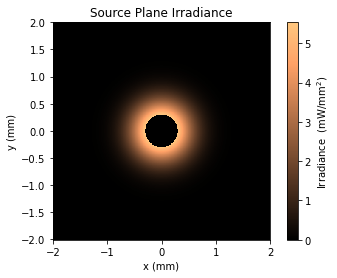

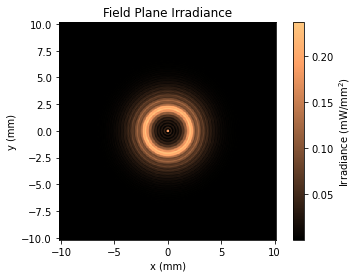

In [46]:
# ------------------------------------------------------------------------------
# FOURIER OPTICS DEMONSTRATION
# Language: Python 3
# ------------------------------------------------------------------------------ 
# Calculates the optical intensity on a screen due to aperture diffraction. 
# The complex scalar field u(x,y) in the  source plane is a concave sperical 
# phasefront (ROC=0.5 m) passing through a circular aperture. The resulting 
# complex scalar field amplitude u'(x',y') in the "field plane" is calculated 
# via Fourier transform.
# ------------------------------------------------------------------------------

import numpy as np
import numpy.matlib as npm
import matplotlib.pyplot as plt

# --------------------
# Physical Parameters
# --------------------
c = 3e8                                             # speed of light in m/s
epsilon0 = 8.854e-12                                # vacuum permittivity in F/m
lam = 633e-9                                        # optical wavelength in m

# -------------
# Source plane
# -------------
xmax=0.002                                          # Src plane area: 4*xmax*ymax m^2
ymax=xmax                                          
Nx = int(2**np.ceil(np.log2(np.abs(512))))          # number of pixels in source plane grid is Nx*Ny
Ny = int(2**np.ceil(np.log2(np.abs(512))))          # (2**... etc gives next power of two for speed)
dxp = 2*xmax/(Nx-1);  dyp=2*ymax/(Ny-1)             # interpixel dist. in the src plane (m)
xp  = npm.repmat( ((np.arange(0,Nx))-np.floor(Nx/2)) *dxp, Ny,1) # x' values at which to calc. source field
yp  = np.transpose(npm.repmat( ((np.arange(0,Ny))-np.floor(Ny/2)) *dyp, Nx,1));  # and y' values

# -----------------------
# ABCD Matrix Components
# -----------------------
# Optical system consists of [ FREE SPACE : LENS : FREE SPACE ].  
L1 = 0.035 ;#0.1e-3;                                # aperture-lens dist. in m
L2 = 0.1;                                          # lens-screen dist. in m
f  = -0.03;                                         # f=Inf corresponds to no lens 
M = np.array([[1,L2],[0,1]]) \
    @ np.array([[1,0],[-1/f,1]]) \
    @ np.array([[1,L1],[0,1]])                      # ABCD matrix of the system
AA = M[0,0]; BB = M[0,1]; CC = M[1,0]; DD = M[1,1]; # The components A, B, C, D

# ---------
# Aperture
# ---------
# Field amplitude is non-zero at these values of x, y (i.e. where it passes 
# through the aperture). The apertures are defined as logical matrixes that 
# are used to index the source field distribution, i.e. Usource(~aperture)=0;
# UIsource(aperture)= <something nonzero>.

a = 3*1e-6;                                      # triangle side length (m)
                # equil. triangular aperture
x0, y0 = 0, 0  # center of the circle
r = 300e-6  # radius of the circle
aperture = np.logical_and.reduce([(xp - x0)**2 + (yp - y0)**2 > r**2])
               
# -------------
# Source Field 
# -------------
# Here, the incident field is assumed to be a Gaussian beam of width "w" 
# and radius of curvature "roc". The beam is clipped by the apeture.
roc = 0.5;                                          # R.O.C. of phasefront at src plane (m)
w  = 750e-6;                                        # beam width of incident beam (m) 
I0 = 7617.5;                                          # max src plane intensity (W/m^2)
E0 = np.sqrt(2*I0/c/epsilon0);                      # m ax field ampl. in src plane (N/C)
k = 2*np.pi/lam;                                    # wave number
r = np.sqrt(xp**2+yp**2);                           # src plane coordss dist from center
usource = E0*np.exp(-r**2/w**2)*np.exp(1j*k*r**2/2/roc); # field ampl. in src plane
usource[np.logical_not(aperture)]=0;                # field is zero except in the aperture
Isource = epsilon0*c/2*np.abs(usource)**2;          # Intensity in the source plane (W/m^2)

# ========================================================================================
# |+|+|+|+|  THE COMPUTATION OCCURS BETWEEN THIS LINE AND THE ONE LIKE IT BELOW  |+|+|+|+|
# ========================================================================================

# h, below is a scale factor to change from the physical units (meters) to new units in
# which all physical lengths are scaled by h=sqrt(B*lam). In the new units, the Fresnel
# integral becomes a standard Fourier transform multiplied by a phase factor. We now scale
# all physical lengths to the new units before performing the fourier tranform. Due to the 
# limitations placed on variable names, x' in the text is the variable f here, y' is g, 
# X' is F, and Y' is G.

h = np.sqrt(BB*lam);                                # scaling factor
dXp = dxp/h; dYp = dyp/h;                           # src interpixel dist in the new units
Xp = xp/h;                                          # src plane x-coords scaled to new units
Yp = yp/h;                                          # src plane y-coords scaled to new units

dX = 1/dXp/Nx;  dY = 1/dYp/Ny;                      # corresponding spatial sampling interval 
                                                    # in field plane after 2 dim. FFT (fft2).
X=npm.repmat((np.arange(0,Nx)-np.floor(Nx/2))  *dX,Ny,1); # Field plane, x-domain (in scaled length)
Y=np.transpose(npm.repmat((np.arange(0,Ny)-np.floor(Ny/2)) *dY,Nx,1)); # and y-domain
dx=dX*h;  dy=dY*h;                                  # field plane sampling interval (in meters)        
x = X*h;  y = Y*h;                                  # Field plane, x and y-domains (in meters)

# Perform 2D FFT on and scale correctly
# -------------------------------------
ufield = \
    -1j*np.exp(1j*np.pi*DD/BB/lam*((x)**2+(y)**2)) \
    *np.fft.fftshift(np.fft.fft2(np.exp(1j*np.pi*AA*(Xp**2+Yp**2))*usource )*dXp*dYp ) # FT2
Ifield = epsilon0*c/2*np.abs(ufield)**2;            # get the intensity

# ========================================================================================
# |+|+|+|+| CODE BELOW CHECKS AND DISPLAYS THE RESULTS |+|+|+|+|+|+|+|+|+|+|+|+|+|+|+|+|+|
# ========================================================================================

# Check energy conservation
# -------------------------
inpow =  np.trapz(np.trapz(Isource))*dxp*dxp;		# integral of intensity in the src plane 
outpow = np.trapz(np.trapz(Ifield))*dx*dy;			# (total power) should equal field plane
print('Power in the source plane:   Pin  =  '+"%8.4f" % ( inpow*1000)+' mW');
print('Power in the field plane:   Pout  =  '+"%8.4f" % (outpow*1000)+' mW');

# Display source plane intensity (Fig. 1)
# ---------------------------------------
fig1 = plt.figure(1)                                # open figure 1
plt.clf()                                           # clear it in case previously used
ax1 = plt.axes()                                    # define a set of axes
c1 = ax1.pcolormesh(xp*1e3,yp*1e3,Isource/1000, cmap='copper')    # plot the source plane irradiance
ax1.set_aspect('equal', 'box')                      # set aspect ratio to be correct
ax1.set_title('Source Plane Irradiance')            # add a title
plt.xlabel('x (mm)')                                # label x axis
plt.ylabel('y (mm)')                                # label y axis
c1bar = fig1.colorbar(c1)                           # add a colorbar
c1bar.set_label('Irradiance  (mW/mm$^2$)', rotation=90) # label the colorbar
plt.savefig('Intput beam Obstruction')
plt.show()                                          # display the plot
                                        

# Display field plane intensity (Fig. 2)
# --------------------------------------
fig2 = plt.figure(2)                                # open figure 2
plt.clf()                                           # clear it in case previously used
ax2 = plt.axes()                                    # define a set of axes
c2 = ax2.pcolormesh(x*1e3,y*1e3,Ifield/1000, cmap='copper')     # plot the field plane irradiance
ax2.set_aspect('equal', 'box')                      # set aspect ratio to be correct
ax2.set_title('Field Plane Irradiance')             # add a title
plt.xlabel('x (mm)')                                # label x axis
plt.ylabel('y (mm)')                                # label y axis
c2bar = fig2.colorbar(c2)                           # add a color bar
c2bar.set_label('Irradiance (mW/mm$^2$)', rotation=90) # label the colorbar
plt.savefig('Output beam Aperture Obstruction')
plt.show()                                          # display the plot

